In [5]:
%cd /content/drive/My Drive/EVA4-Phase2/GANs

/content/drive/My Drive/EVA4-Phase2/GANs


### Imports

In [6]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as tvutils
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
from IPython.display import HTML

#### Set seed for reproducibility

In [ ]:
manualSeed = 999
#uncomment to see different results each time
#manualSeed = random.randint(1, 1000)

random.seed(manualSeed)
torch.manual_seed(manualSeed)

### Defining params

In [ ]:
class Args:
    # Root directory for dataset
    dataroot = "Dataset/"
    datafolder = "Dataset/cars_sedans"

    # Number of workers for dataloader
    workers = 2

    # Batch size during training
    batch_size = 128

    # Spatial size of training images. All images will be resized to this
    #   size using a transformer.
    image_size = 128

    # Number of channels in the training images. For color images this is 3
    nc = 3

    # Size of z latent vector (i.e. size of generator input)
    nz = 100

    # Size of feature maps in generator
    ngf = 64

    # Size of feature maps in discriminator
    ndf = 64

    # Number of training epochs
    num_epochs = 50

    # Learning rate for optimizers
    lr = 0.0002

    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5

    # Number of GPUs available. Use 0 for CPU mode.
    ngpu = 1

    outf = "/content/drive/My Drive/EVA4-Phase2/GAN_Output"

#### Display image shape

In [ ]:
for idx, im_name in enumerate(os.listdir(Args.datafolder)):
  im_path = os.path.join(Args.datafolder, im_name)
  im = Image.open(im_path)
  w, h = im.size

  print(w,h)
  if idx == 5:
    break

print("Padding required top bottom: ", (w-h)//2)
print("Number of train images: ", len(os.listdir(Args.datafolder)))

766 377
766 377
766 377
766 377
766 377
766 377
Padding required top bottom:  194
Number of train images:  4965


### Load Data

In [ ]:
# Create the dataset
dataset = datasets.ImageFolder(root=Args.dataroot,
                           transform=transforms.Compose([
                               transforms.Pad((0, (w-h)//2), padding_mode='constant'),
                               transforms.Resize(Args.image_size),
                               transforms.CenterCrop(Args.image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=Args.batch_size,
                                         shuffle=True, num_workers=Args.workers)

print("Total number of batches: ", len(dataloader))

Total number of batches:  39


### Dsplay some training images

In [ ]:
print(torch.cuda.is_available())

True


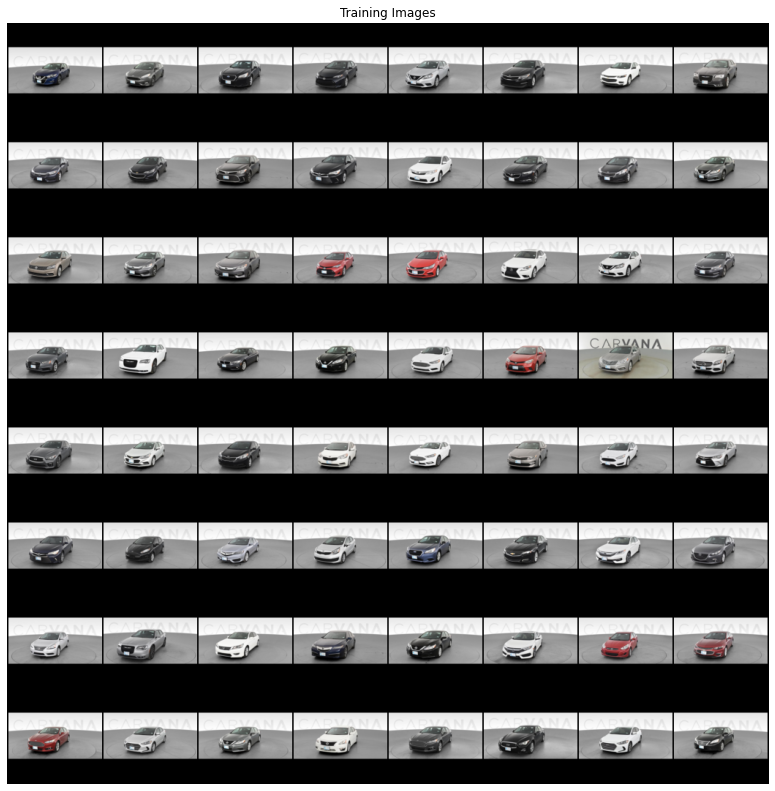

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and Args.ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(tvutils.make_grid(real_batch[0].to(device)[:64], normalize=True).cpu(),(1,2,0)))

### Custom weights initialization

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Code for generator

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        nz = Args.nz
        ngf = Args.ngf
        nc = Args.nc
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.SELU(inplace=True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.SELU(inplace=True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.SELU(inplace=True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.SELU(inplace=True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.SELU(inplace=True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

### Instantiate generator by using weights-init function

In [ ]:
# Create the generator
netG = Generator(Args.ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (Args.ngpu > 1):
    netG = nn.DataParallel(netG, list(range(Args.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SELU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): SELU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): SELU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [ ]:
summary(netG, (100, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1       [-1, 1024, 131, 131]       1,638,400
       BatchNorm2d-2       [-1, 1024, 131, 131]           2,048
              SELU-3       [-1, 1024, 131, 131]               0
   ConvTranspose2d-4        [-1, 512, 262, 262]       8,388,608
       BatchNorm2d-5        [-1, 512, 262, 262]           1,024
              SELU-6        [-1, 512, 262, 262]               0
   ConvTranspose2d-7        [-1, 256, 524, 524]       2,097,152
       BatchNorm2d-8        [-1, 256, 524, 524]             512
              SELU-9        [-1, 256, 524, 524]               0
  ConvTranspose2d-10      [-1, 128, 1048, 1048]         524,288
      BatchNorm2d-11      [-1, 128, 1048, 1048]             256
             SELU-12      [-1, 128, 1048, 1048]               0
  ConvTranspose2d-13       [-1, 64, 2096, 2096]         131,072
      BatchNorm2d-14       [-1, 64, 209

### Code for Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        nc = Args.nc
        ndf = Args.ndf
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False),
            nn.SELU(inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.SELU(inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.SELU(inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.SELU(inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.SELU(inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )

    def forward(self, input):
        return self.main(input)

### Instantiate discriminator

In [ ]:
netD = Discriminator(Args.ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (Args.ngpu > 1):
    netD = nn.DataParallel(netD, list(range(Args.ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): SELU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SELU(inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): SELU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SELU(inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): SELU(inplace=True)
    (14): Conv2d

In [ ]:
summary(netD, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
              SELU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
              SELU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
              SELU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
             SELU-11            [-1, 512, 8, 8]               0
           Conv2d-12           [-1, 1024, 4, 4]       8,388,608
      BatchNorm2d-13           [-1, 1024, 4, 4]           2,048
             SELU-14           [-1, 102

### Loss function and optimizers

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, Args.nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=Args.lr, betas=(Args.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=Args.lr, betas=(Args.beta1, 0.999))

In [ ]:
print(device)

cuda:0


### Begin Training

In [ ]:
from tqdm import tqdm
for epoch in range(Args.num_epochs):
    pbar = tqdm(dataloader)
    for i, data in enumerate(pbar, 0):
        if i < 38:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            netD.zero_grad()
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((Args.batch_size,), real_label,
                              dtype=real_cpu.dtype, device=device)

            output = netD(real_cpu)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, Args.nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            pbar.set_description(desc = f'[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, Args.num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            if i % 37 == 0:
                tvutils.save_image(real_cpu,
                        '%s/real_samples.png' % Args.outf,
                        normalize=True)
                fake = netG(fixed_noise)
                tvutils.save_image(fake.detach(),
                        '%s/fake_samples_epoch_%03d.png' % (Args.outf, epoch),
                        normalize=True)

            #if opt.dry_run:
                #break
    # do checkpointing
    if epoch%10 == 0:
      torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (Args.outf, epoch))
      torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (Args.outf, epoch))

  0%|          | 0/39 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
[0/50][37/39] Loss_D: 0.1417 Loss_G: 37.2667 D(x): 0.9994 D(G(z)): 0.0309 / 0.0002: 100%|██████████| 39/39 [21:06<00:00, 32.48s/it]
[1/50][37/39] Loss_D: 0.1213 Loss_G: 41.3417 D(x): 1.0000 D(G(z)): 0.0157 / 0.0039: 100%|██████████| 39/39 [00:51<00:00,  1.32s/it]
[2/50][37/39] Loss_D: 0.9012 Loss_G: 40.8820 D(x): 1.0000 D(G(z)): 0.0362 / 0.0078: 100%|██████████| 39/39 [00:51<00:00,  1.31s/it]
[3/50][37/39] Loss_D: 42.5865 Loss_G: 20.4788 D(x): 1.0000 D(G(z)): 0.5595 / 0.5062: 100%|██████████| 39/39 [00:50<00:00,  1.29s/it]
[4/50][37/39] Loss_D: 0.1559 Loss_G: 9.1291 D(x): 0.9921 D(G(z)): 0.0565 / 0.0069: 100%|██████████|

Text(0.5, 1.0, 'Fake')

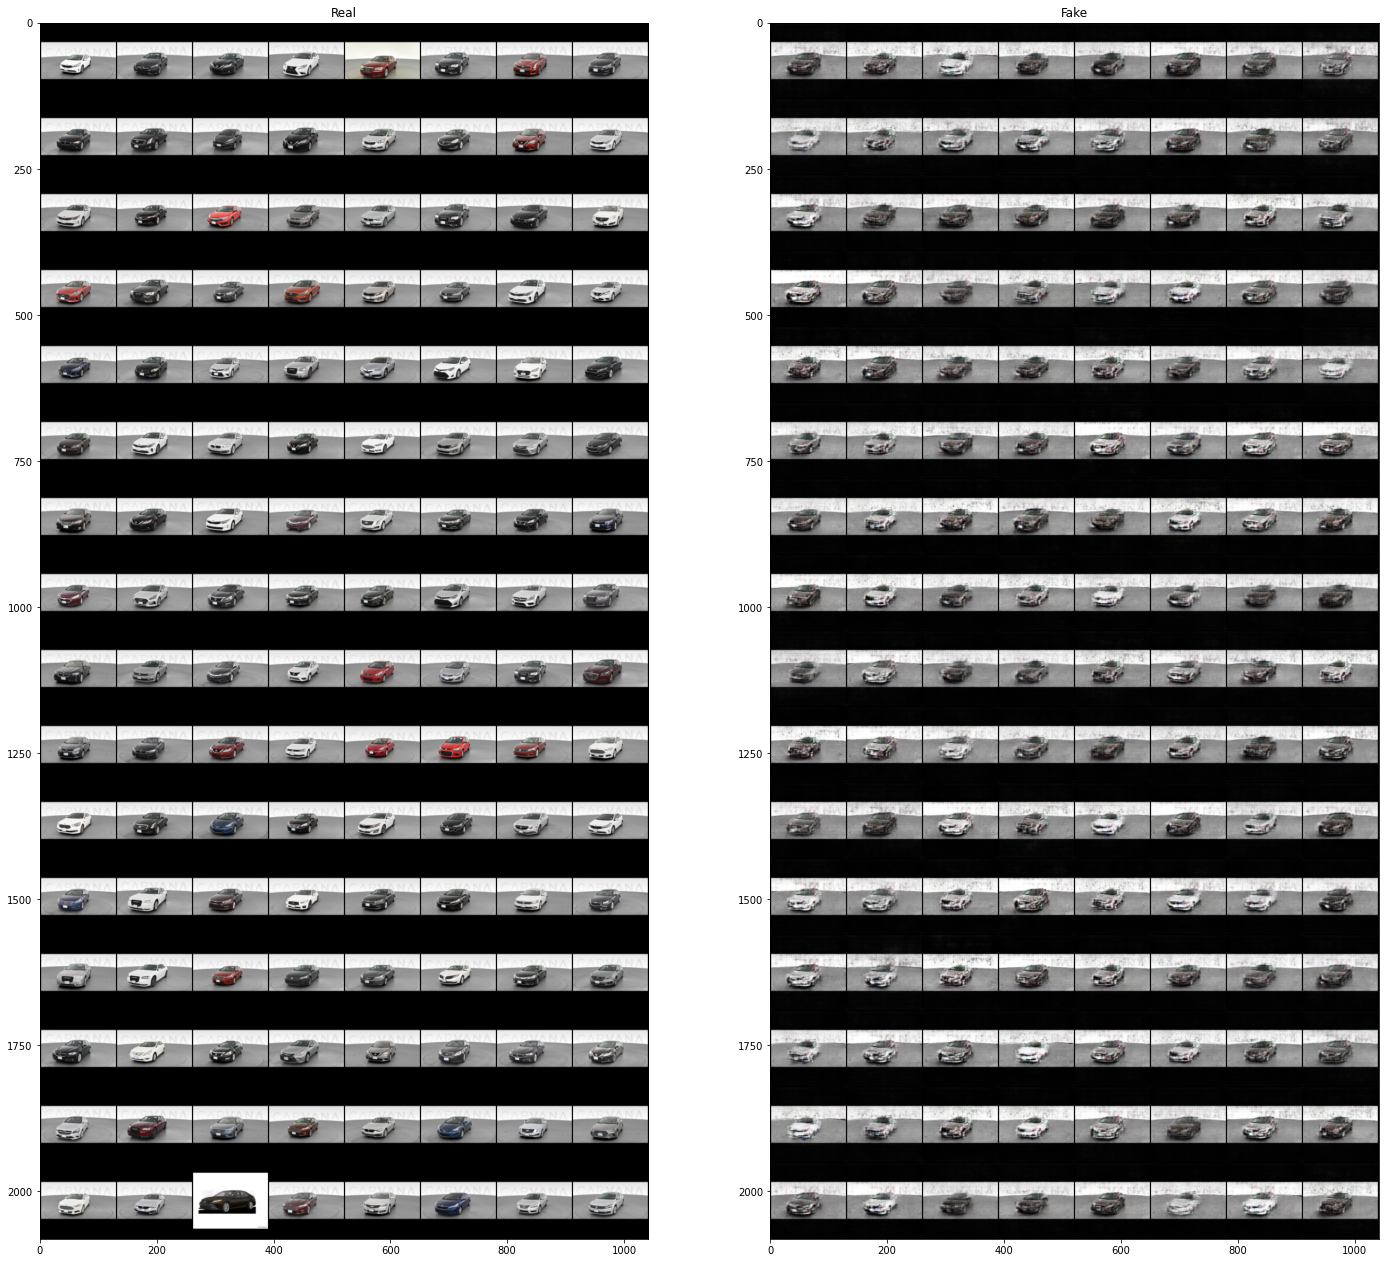

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (24,24))
real = Image.open('/content/drive/My Drive/EVA4-Phase2/GAN_Output/real_samples.png')
fake = Image.open('/content/drive/My Drive/EVA4-Phase2/GAN_Output/fake_samples_epoch_049.png')
ax[0].imshow(real)
ax[0].set_title("Real")
ax[1].imshow(fake)
ax[1].set_title("Fake")
